*Travel dataset description*

### Overview

"Travel.com" company wants to enable and establish a viable business model to expand the customer base. One of the ways to expand the customer base is to introduce a new offering of packages. Currently, there are 5 types of packages the company is offering - Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages. However, the marketing cost was quite high because customers were contacted at random without looking at the available information. The company is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being. However, this time company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient. 

### Dataset 

https://www.kaggle.com/datasets/susant4learning/holiday-package-purchase-prediction

- **CustomerID**: Unique customer ID 
- **ProdTaken**: Taken product: 1/0 (Target) 
- **Age**: Age of the customer 
- **TypeofContact**: How customer was contacted (Company invited or Self Inquiry)
- **CityTier**: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. 
- **DurationOfPitch**: Duration of the pitch by a salesperson to the customer. (minute)
- **Occupation**: Occupation of the customer. 
- **Gender**: Gender of the customer. 
- **NumberOfPersonVisiting**: Total number of persons planning to take the trip with the customer. 
- **NumberOfFollowups**: Total number of follow-ups has been done by the salesperson after the sales pitch. 
- **ProductPitched**: Product pitched by the salesperson. 
- **PreferredPropertyStar**: Preferred hotel property rating by customer. 
- **MaritalStatus**: Marital status of the customer.
- **NumberOfTrips**: Average number of trips in a year by customer. 
- **Passport**: The customer has a passport or not (0: No, 1: Yes). 
- **PitchSatisfactionScore**: Sales pitch satisfaction score. 
- **OwnCar**: Whether the customers own a car or not (0: No, 1: Yes). 
- **NumberOfChildrenVisiting**: Total number of children with age less than 5 planning to take the trip with the customer. 
- **Designation**: Designation of the customer in the current organization. 
- **MonthlyIncome**: Gross monthly income of the customer. 

### Tasks:

We need to analyze the customers' data and information to provide recommendations to the Policy Maker and Marketing Team and also build a model to predict the potential customer who is going to purchase the newly introduced travel package.

- To predict which customer is more likely to purchase the newly introduced travel package.
- Which variables are most significant. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import os

from sklearn.model_selection import cross_val_score, train_test_split
import category_encoders as ce
import statsmodels.api as sm

from sklearn.metrics import roc_curve, auc
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
import time
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold

### Helper funtions:

In [2]:
def corr(ds, columns=None):
    if columns is None:
        correlation = ds.corr()
    else:
        correlation = ds[columns].corr()

    # Generate a lower triangle mask
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the heatmap
    sns.heatmap(correlation,
                mask=mask,
                square=True,
                linewidths=.5,
                cmap='viridis',
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 10})

    # Set the tick labels rotation
    ax.set_xticklabels(correlation.columns, rotation=90)
    ax.set_yticklabels(correlation.columns, rotation=0)

    # Set the style
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [3]:
def auc_plot(y_test, y_pred_test_proba):
    '''
    Plot the ROC curve.
    '''
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    auc_keras = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras), color="g")
    plt.grid(axis='both', linestyle='--', color="#add8e6")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

In [4]:
def plot_feature_importances(model, feature_names):
    '''
    Plot the feature importances of a Random Forest classifier.
    '''
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.bar(range(len(importances)), importances[indices], color='g')
    plt.xticks(range(len(importances)), feature_names[indices], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()

In [5]:
def get_feature_importances(X_train, rf_model):
    rf_importances = pd.DataFrame({
        "Column": X_train.columns,
        "Importance": rf_model.feature_importances_
    })
    rf_importances = rf_importances.sort_values(by="Importance", ascending=False)
    return rf_importances

### Loading the data

In [6]:
travel = pd.read_csv('Travel.csv')

In [7]:
travel.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [8]:
travel.info()
# Dataset has 4888 entries and 20 columns. Some columns have missing values.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [9]:
# Reformat variables.
# string_cols = ['TypeofContact','Occupation','Gender','ProductPitched','MaritalStatus','Designation']
# travel[string_cols] = travel[string_cols].astype('string')

## Data Understanding

### Summary Statistics

In [10]:
travel.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,4888.0,NaN,NaN,NaN,202443.5,1411.188388,200000.0,201221.75,202443.5,203665.25,204887.0
ProdTaken,4888.0,NaN,NaN,NaN,0.188216,0.390925,0.0,0.0,0.0,0.0,1.0
Age,4662.0,NaN,NaN,NaN,37.622265,9.316387,18.0,31.0,36.0,44.0,61.0
TypeofContact,4863,2,Self Enquiry,3444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityTier,4888.0,NaN,NaN,NaN,1.654255,0.916583,1.0,1.0,1.0,3.0,3.0
DurationOfPitch,4637.0,NaN,NaN,NaN,15.490835,8.519643,5.0,9.0,13.0,20.0,127.0
Occupation,4888,4,Salaried,2368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,4888,3,Male,2916,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberOfPersonVisiting,4888.0,NaN,NaN,NaN,2.905074,0.724891,1.0,2.0,3.0,3.0,5.0
NumberOfFollowups,4843.0,NaN,NaN,NaN,3.708445,1.002509,1.0,3.0,4.0,4.0,6.0


- Prodtaken: Only 18.8% of customers have taken a product.
- Age: The minimum age is 18, and the maximum age is 61. Average is 37.6. 
- TypeofContact: The most frequent type of contact is "Self Enquiry," which appears 3,444 times.
- DurationOfPitch: The shortest pitch duration is 5 minutes, while the longest is 127 minutes. Average is 15.4. 
- Occupation: "Salaried" being the most common, appearing 2,368 times.
- Gender: There are three categories: "Male" is the most common, appearing 2,916 times. 
- NumberOfPersonVisiting: The average number of people visiting is approximately 2.9. The values range from 1 to 5.
- NumberOfFollowups: The mean number of follow-ups is approximately 3.7. The values range from 1 to 6.
- ProductPitched: This column indicates the product pitched to customers. There are five different product types, with "Basic" being the most common, appearing 1,842 times.
- PreferredPropertyStar: The average preferred star rating is approximately 3.6. The values range from 3 to 5.
- MaritalStatus: There are four categories, with "Married" being the most common, appearing 2,340 times.
- NumberOfTrips: The mean number of trips is approximately 3.2. The values range from 1 to 22.
- Passport: Approximately 29.1% of customers have a passport.
- PitchSatisfactionScore: The average score is approximately 3.1. The values range from 1 to 5.
- OwnCar: About 62.0% of customers own a car.
- NumberOfChildrenVisiting: The average number of children visiting is approximately 1.2, with a standard deviation of 0.9. The values range from 0 to 3.
- Designation: There are five different designations, with "Executive" being the most common, appearing 1,842 times.
- MonthlyIncome: The average monthly income is approximately 23,620. The minimum income is 1,000, and the maximum income is 98,678 dollars.

In [11]:
travel.duplicated().sum()
# No duplicate.

0

### Frequency of Values 

In [12]:
for col_name in travel.columns: 
    print(f'Column {col_name} has the following frequencies:')
    print(travel[col_name].value_counts(dropna=False))
    print('=' * 30)

Column CustomerID has the following frequencies:
CustomerID
200000    1
203256    1
203263    1
203262    1
203261    1
         ..
201628    1
201627    1
201626    1
201625    1
204887    1
Name: count, Length: 4888, dtype: int64
Column ProdTaken has the following frequencies:
ProdTaken
0    3968
1     920
Name: count, dtype: int64
Column Age has the following frequencies:
Age
35.0    237
36.0    231
NaN     226
34.0    211
31.0    203
30.0    199
32.0    197
33.0    189
37.0    185
29.0    178
38.0    176
41.0    155
39.0    150
28.0    147
40.0    146
42.0    142
27.0    138
43.0    130
46.0    121
45.0    116
26.0    106
44.0    105
51.0     90
47.0     88
50.0     86
25.0     74
52.0     68
53.0     66
49.0     65
48.0     65
55.0     64
54.0     61
56.0     58
24.0     56
23.0     46
22.0     46
59.0     44
21.0     41
20.0     38
19.0     32
58.0     31
57.0     29
60.0     29
18.0     14
61.0      9
Name: count, dtype: int64
Column TypeofContact has the following frequencies:


## Data Cleaning & Transformation

In [13]:
# Replace "Fe male" with "Female" (case-insensitive) and handle leading/trailing whitespaces
travel['Gender'] = travel['Gender'].str.replace(r'^\s*Fe\s*male\s*$', 'Female', regex=True, flags=re.IGNORECASE)

In [14]:
travel['Gender'].value_counts()

Gender
Male      2916
Female    1972
Name: count, dtype: int64

### Missing Values

In [15]:
count = travel.isnull().sum().sort_values(ascending=False)
percentage = ((travel.isnull().sum()/len(travel)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1, 
keys = ['Count', 'Percentage'])

print('Count and percantage of missing values for the columns:')

missing_data

Count and percantage of missing values for the columns:


,Count,Percentage
DurationOfPitch,251,5.135025
MonthlyIncome,233,4.766776
Age,226,4.623568
NumberOfTrips,140,2.864157
NumberOfChildrenVisiting,66,1.350245
NumberOfFollowups,45,0.920622
PreferredPropertyStar,26,0.531915
TypeofContact,25,0.511457
Designation,0,0.000000
OwnCar,0,0.000000


### Impute NaN Values

In [16]:
travel['Age'].mean()

37.62226512226512

In [17]:
# Imputed with mean since there is no outliers for 'Age' column. 
travel['Age'] = travel['Age'].fillna(38)

In [18]:
travel['MonthlyIncome'].median()

22347.0

In [19]:
# Preferred median imputation because of the outliers. 
travel['MonthlyIncome'] = travel['MonthlyIncome'].fillna(22347)

In [20]:
mode_cols = ['NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'TypeofContact']

for mode_col in mode_cols:
    mode_value = travel[mode_col].mode().values[0]
    print(f"Mode of {mode_col}: {mode_value}")

    # Fill NaN values with the mode in the specified column
    travel[mode_col].fillna(mode_value, inplace=True)

Mode of NumberOfFollowups: 4.0
Mode of PreferredPropertyStar: 3.0
Mode of NumberOfTrips: 2.0
Mode of NumberOfChildrenVisiting: 1.0
Mode of TypeofContact: Self Enquiry


In [21]:
for mode_value_counts in mode_cols: 
    mode_counts = travel[mode_value_counts].value_counts()
    print(mode_counts)

NumberOfFollowups
4.0    2113
3.0    1466
5.0     768
2.0     229
1.0     176
6.0     136
Name: count, dtype: int64
PreferredPropertyStar
3.0    3019
5.0     956
4.0     913
Name: count, dtype: int64
NumberOfTrips
2.0     1604
3.0     1079
1.0      620
4.0      478
5.0      458
6.0      322
7.0      218
8.0      105
19.0       1
21.0       1
20.0       1
22.0       1
Name: count, dtype: int64
NumberOfChildrenVisiting
1.0    2146
2.0    1335
0.0    1082
3.0     325
Name: count, dtype: int64
TypeofContact
Self Enquiry       3469
Company Invited    1419
Name: count, dtype: int64


In [22]:
# Since the values are close to eachother. It is applied weighted imputation.

# Calculate the weights based on value frequencies
value_counts = travel['DurationOfPitch'].value_counts()
weights = value_counts / value_counts.sum()

# Create an array of unique values with their corresponding weights
unique_values = weights.index.tolist()
unique_weights = weights.values.tolist()

# Create a mask for missing values in the column
mask = travel['DurationOfPitch'].isnull()

# Set a random seed for reproducibility
np.random.seed(42)

# Generate random imputations based on weights
imputations = np.random.choice(unique_values, size=mask.sum(), p=unique_weights)

# Create a copy of the DataFrame to avoid modifying the original data
travel_imputed = travel.copy()

# Assign the imputations to the missing values in the copy DataFrame
travel_imputed.loc[mask, 'DurationOfPitch'] = imputations

# Verify the imputed values
imputed_values = travel_imputed['DurationOfPitch'].loc[mask]
print("Imputed values:")
print(imputed_values)

# Update the original DataFrame with the imputed values
travel['DurationOfPitch'].update(travel_imputed['DurationOfPitch'])

Imputed values:
46      16.0
75      28.0
76      30.0
84      11.0
103      7.0
        ... 
4215    15.0
4427    19.0
4641    33.0
4678    21.0
4825     6.0
Name: DurationOfPitch, Length: 251, dtype: float64


In [23]:
travel['DurationOfPitch'].value_counts()

DurationOfPitch
9.0      512
7.0      361
8.0      355
6.0      326
16.0     293
15.0     278
10.0     262
14.0     256
13.0     230
11.0     217
12.0     210
17.0     179
30.0     103
22.0      90
31.0      86
23.0      85
29.0      81
26.0      78
18.0      77
24.0      77
32.0      76
21.0      76
27.0      75
25.0      75
20.0      69
35.0      69
28.0      65
19.0      62
33.0      61
34.0      52
36.0      44
5.0        6
126.0      1
127.0      1
Name: count, dtype: int64

### Outliers Detection

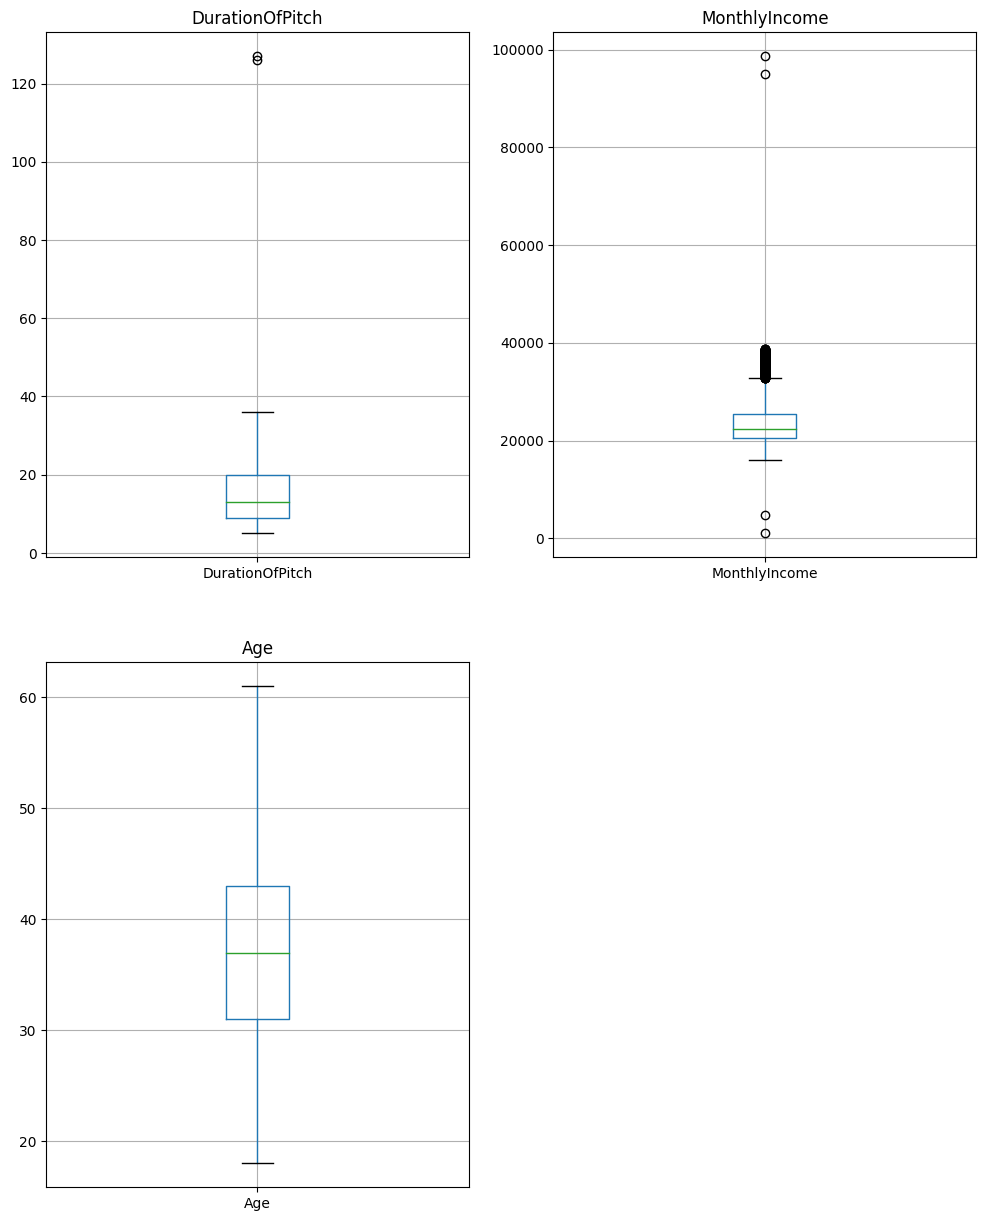

In [24]:
outlier_cols = ['DurationOfPitch', 'MonthlyIncome', 'Age']

outliers_df = travel[outlier_cols]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,15))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    outliers_df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

for j in range(len(outlier_cols), len(axes)):
    axes[j].axis('off')

plt.show() 

In [25]:
# Loop through each column and identify and print the outliers.
for col in outliers_df.columns:
    q1 = outliers_df[col].quantile(0.25)
    q3 = outliers_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = outliers_df[(outliers_df[col] < lower_bound) | (outliers_df[col] > upper_bound)][col]
    print(f"Outliers for {col}:")
    print(outliers)

Outliers for DurationOfPitch:
1434    126.0
3878    127.0
Name: DurationOfPitch, dtype: float64
Outliers for MonthlyIncome:
25      34094.0
29      33947.0
38      95000.0
45      34545.0
62      33740.0
         ...   
4851    35801.0
4859    35558.0
4868    36539.0
4869    37865.0
4870    38395.0
Name: MonthlyIncome, Length: 375, dtype: float64
Outliers for Age:
Series([], Name: Age, dtype: float64)


### FIlter Outliers

In [26]:
# Define the threshold values for each column and remove extreme outliers. 
DurationOfPitch_threshold = 120
MonthlyIncome_threshold_above = 80000 
MonthlyIncome_threshold_under = 5000


# Filter the rows where any of the specified columns have values greater than its threshold value
filtered_travel = travel[(travel['DurationOfPitch'] <= DurationOfPitch_threshold) &
                         (travel['MonthlyIncome'] <= MonthlyIncome_threshold_above) &
                         (travel['MonthlyIncome'] >= MonthlyIncome_threshold_under)].copy()

In [27]:
filtered_travel.shape

(4882, 20)

After imputing missing values and filtering outliers, we have 4882 data out of 4888.

## Data Exploration

### 'target'

In [28]:
filtered_travel.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,38.0,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [29]:
# Imbalanced data. 
filtered_travel['ProdTaken'].value_counts()

ProdTaken
0    3962
1     920
Name: count, dtype: int64

<Axes: xlabel='ProdTaken'>

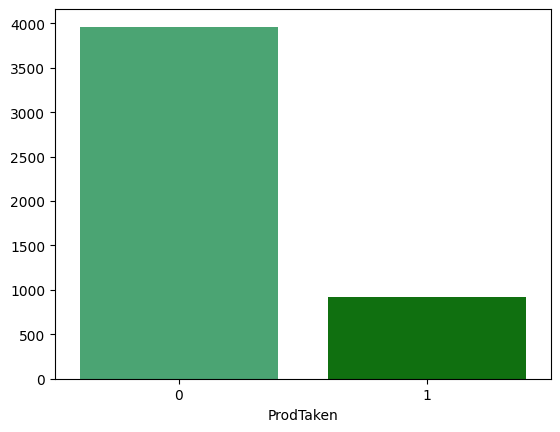

In [30]:
value_counts = filtered_travel['ProdTaken'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, palette=['mediumseagreen', 'green'])

### Encoding Categorical Values

In [31]:
encoder = ce.OrdinalEncoder(cols=['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation'])
filtered_travel = encoder.fit_transform(filtered_travel)

In [32]:
filtered_travel.groupby('ProdTaken').mean()

,CustomerID,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
ProdTaken,,,,,,,,,,,,,,,,,,,
0,202406.084806,38.26628,1.279404,1.615851,15.09263,2.094397,1.589601,2.902322,3.657244,2.092378,3.540384,2.614336,3.180212,0.233216,3.044927,0.622918,1.181979,2.092378,23854.794548
1,202609.086957,34.92500,1.336957,1.819565,16.86087,2.228261,1.628261,2.919565,3.942391,2.021739,3.741304,2.384783,3.291304,0.536957,3.223913,0.608696,1.198913,2.021739,22178.885870


Observations: 

The average age of customers who bought the product is lower than that of the customer who did not. Customers who took the product have slightly more follow-ups and duration of pitch on average compared to those who did not take the product. Customers who took the product are more likely to have a passport compared to those who did not take the product.

### 'TypeofContact'

In [33]:
filtered_travel.groupby('TypeofContact').mean()

,CustomerID,ProdTaken,Age,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
TypeofContact,,,,,,,,,,,,,,,,,,,
1,202436.148341,0.176046,37.772872,1.649351,15.317172,2.145743,1.597403,2.903896,3.700433,2.107648,3.593939,2.566522,3.213276,0.290332,3.061760,0.621356,1.181530,2.107648,23619.081962
2,202464.371207,0.218772,37.303458,1.666196,15.691602,2.055752,1.595625,2.909668,3.736768,2.009174,3.539873,2.582216,3.171489,0.290755,3.119972,0.617502,1.194072,2.009174,23343.085392


### 'Gender'

In [34]:
filtered_travel.groupby('Gender').mean()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
Gender,,,,,,,,,,,,,,,,,,,
1,202446.921748,0.173780,38.064024,1.291159,1.679878,15.362805,2.134146,2.913618,3.715447,2.086382,3.600610,2.567581,3.214939,0.309959,3.074187,0.630081,1.163110,2.086382,23720.741362
2,202442.596431,0.198353,37.347975,1.289636,1.636925,15.468428,2.109815,2.900137,3.707962,2.074125,3.563143,2.573439,3.191833,0.277282,3.081675,0.613590,1.200069,2.074125,23416.215511


### 'ProductPitched'

In [35]:
filtered_travel.groupby('ProductPitched').mean()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
ProductPitched,,,,,,,,,,,,,,,,,,,
1,202430.166474,0.117919,37.409827,1.312717,1.929480,15.826012,2.124855,1.582659,2.891908,3.707514,3.560694,2.739306,3.279191,0.276301,3.004624,0.611561,1.178035,1.0,22641.058960
2,202468.409140,0.300326,33.424374,1.279652,1.348205,15.083787,2.104461,1.631121,2.930903,3.695321,3.585419,2.363983,3.094668,0.307943,3.084875,0.587595,1.199674,2.0,19969.767682
3,202430.997305,0.167116,40.578167,1.293801,1.800539,16.000000,2.202156,1.560647,2.920485,3.791105,3.646900,2.902965,3.315364,0.283019,3.061995,0.652291,1.177898,3.0,26637.749326
4,202450.590643,0.058480,48.026316,1.280702,1.730994,16.230994,2.035088,1.532164,2.845029,3.576023,3.578947,2.280702,3.356725,0.304094,3.356725,0.701754,1.064327,4.0,32241.046784
5,202392.356522,0.086957,48.065217,1.208696,1.443478,12.100000,2.060870,1.643478,2.847826,3.804348,3.430435,2.321739,2.865217,0.260870,3.226087,0.721739,1.326087,5.0,35878.947826


### 'MaritalStatus'

In [36]:
filtered_travel.groupby('MaritalStatus').mean()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
MaritalStatus,,,,,,,,,,,,,,,,,,,
1,202020.835886,0.332604,35.961707,1.305252,1.596280,15.138950,2.128009,1.578775,2.671772,3.612691,2.165208,3.555799,2.919037,0.304158,3.095186,0.597374,0.998906,2.165208,22285.643326
2,201767.405063,0.130802,38.534810,1.260549,1.679325,15.328059,2.130802,1.594937,2.932489,3.677215,2.145570,3.573840,3.193038,0.289030,3.181435,0.651899,1.156118,2.145570,23938.578059
3,202714.301967,0.139435,38.247220,1.289991,1.618477,15.581694,2.119760,1.616766,2.931138,3.674936,2.101796,3.592387,3.266895,0.291702,3.045338,0.615056,1.209581,2.101796,23789.167665
4,203027.398827,0.243402,36.539589,1.312317,1.819648,15.412023,2.092375,1.555718,3.093842,4.013196,1.793255,3.565982,3.365103,0.269795,3.027859,0.624633,1.391496,1.793255,23805.494135


### 'Designation'

In [37]:
filtered_travel.groupby('Designation').mean()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
Designation,,,,,,,,,,,,,,,,,,,
1,202430.166474,0.117919,37.409827,1.312717,1.929480,15.826012,2.124855,1.582659,2.891908,3.707514,1.0,3.560694,2.739306,3.279191,0.276301,3.004624,0.611561,1.178035,22641.058960
2,202468.409140,0.300326,33.424374,1.279652,1.348205,15.083787,2.104461,1.631121,2.930903,3.695321,2.0,3.585419,2.363983,3.094668,0.307943,3.084875,0.587595,1.199674,19969.767682
3,202430.997305,0.167116,40.578167,1.293801,1.800539,16.000000,2.202156,1.560647,2.920485,3.791105,3.0,3.646900,2.902965,3.315364,0.283019,3.061995,0.652291,1.177898,26637.749326
4,202450.590643,0.058480,48.026316,1.280702,1.730994,16.230994,2.035088,1.532164,2.845029,3.576023,4.0,3.578947,2.280702,3.356725,0.304094,3.356725,0.701754,1.064327,32241.046784
5,202392.356522,0.086957,48.065217,1.208696,1.443478,12.100000,2.060870,1.643478,2.847826,3.804348,5.0,3.430435,2.321739,2.865217,0.260870,3.226087,0.721739,1.326087,35878.947826


### 'Occupation'

In [38]:
filtered_travel.groupby('Occupation').mean()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
Occupation,,,,,,,,,,,,,,,,,,,
1,202448.895939,0.175127,37.660321,1.306261,1.520305,15.132826,1.602369,2.911168,3.711929,2.088832,3.548223,2.577411,3.186125,0.288494,3.115059,0.633672,1.181049,2.088832,23532.737733
2,201224.000000,1.000000,37.500000,1.000000,1.000000,8.500000,2.000000,3.500000,4.500000,2.000000,3.000000,1.000000,7.500000,1.000000,3.000000,0.000000,0.500000,2.000000,18929.000000
3,202439.542226,0.184261,37.805662,1.279750,1.819578,15.916027,1.591171,2.904031,3.699136,2.068138,3.608925,2.573896,3.163628,0.293666,3.003839,0.598848,1.189060,2.068138,23672.031670
4,202448.203704,0.277778,36.692130,1.254630,1.592593,14.696759,1.592593,2.879630,3.759259,2.078704,3.597222,2.530093,3.444444,0.282407,3.240741,0.652778,1.192130,2.078704,22952.562500


### 'TypeofContact'

<Axes: xlabel='TypeofContact'>

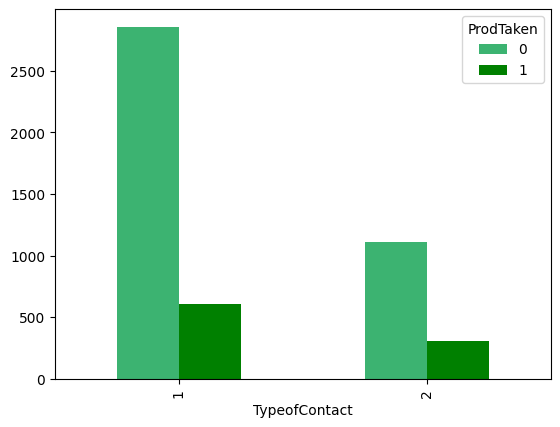

In [39]:
%matplotlib inline
pd.crosstab(filtered_travel.TypeofContact,filtered_travel.ProdTaken).plot(kind='bar', color=['mediumseagreen', 'g'])

TypeofContact seems a good predictor of the outcome variable.

### 'MaritalStatus'

<Axes: xlabel='MaritalStatus'>

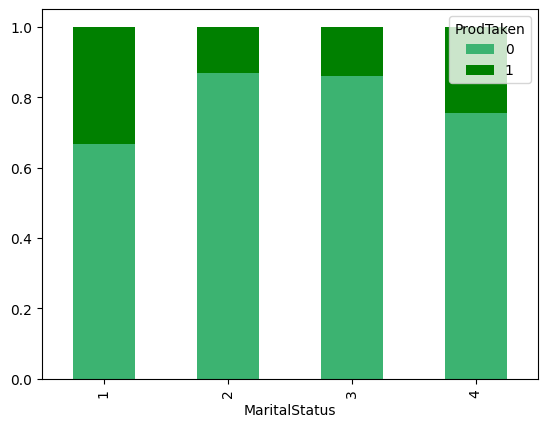

In [40]:
table = pd.crosstab(filtered_travel.MaritalStatus, filtered_travel.ProdTaken)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', color=['mediumseagreen', 'green'], stacked=True)

MaritalStatus does not seem a strong predictor.

### 'Gender'

<Axes: xlabel='Gender'>

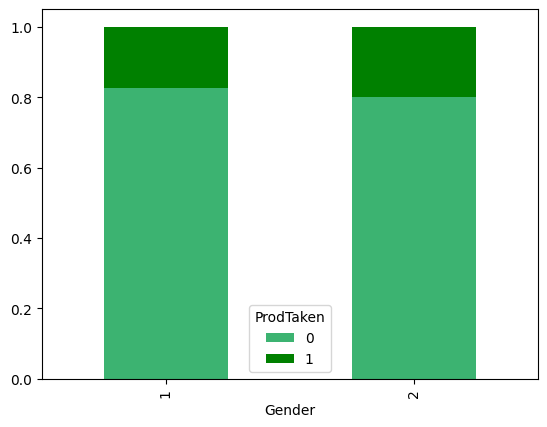

In [41]:
table = pd.crosstab(filtered_travel.Gender, filtered_travel.ProdTaken)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', color=['mediumseagreen', 'green'], stacked=True)

Hard to see, but gender might not be a good predictor for outcome variable.

### 'ProductPitched'

<Axes: xlabel='ProductPitched'>

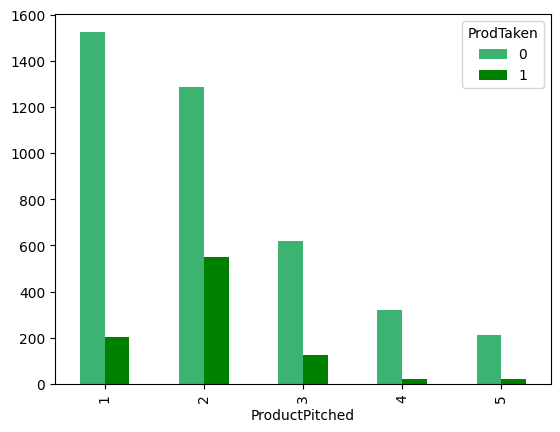

In [42]:
%matplotlib inline
pd.crosstab(filtered_travel.ProductPitched, filtered_travel.ProdTaken).plot(kind='bar', color=['mediumseagreen', 'green'])

ProductPitched seems a good predictor of the outcome variable.

### 'Designation'

<Axes: xlabel='Designation'>

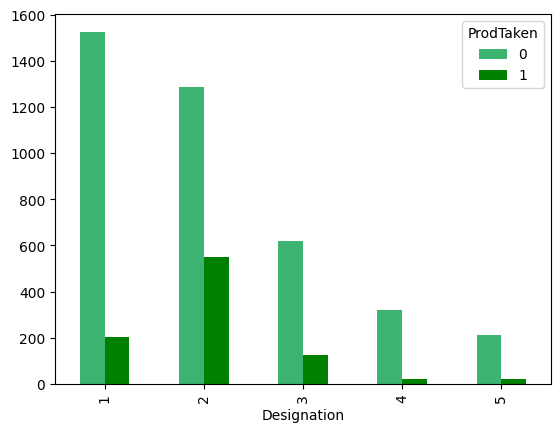

In [43]:
%matplotlib inline
pd.crosstab(filtered_travel.Designation, filtered_travel.ProdTaken).plot(kind='bar', color=['mediumseagreen', 'green'])

Designation seems like a strong predictor for outcome variable.

### 'Occupation'

<Axes: xlabel='Occupation'>

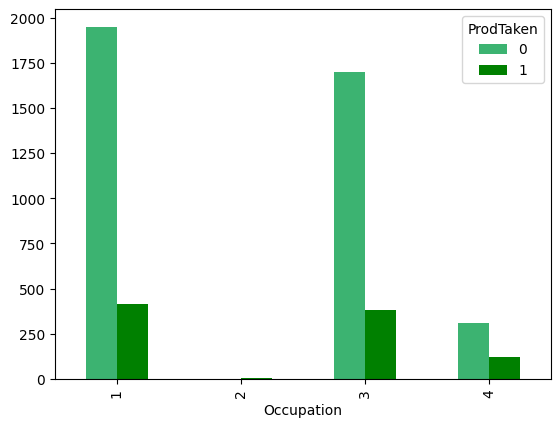

In [44]:
%matplotlib inline
pd.crosstab(filtered_travel.Occupation, filtered_travel.ProdTaken).plot(kind='bar', color=['mediumseagreen', 'green'])

Occupation seems like a strong predictor for outcome variable.

### Correlation Matrix

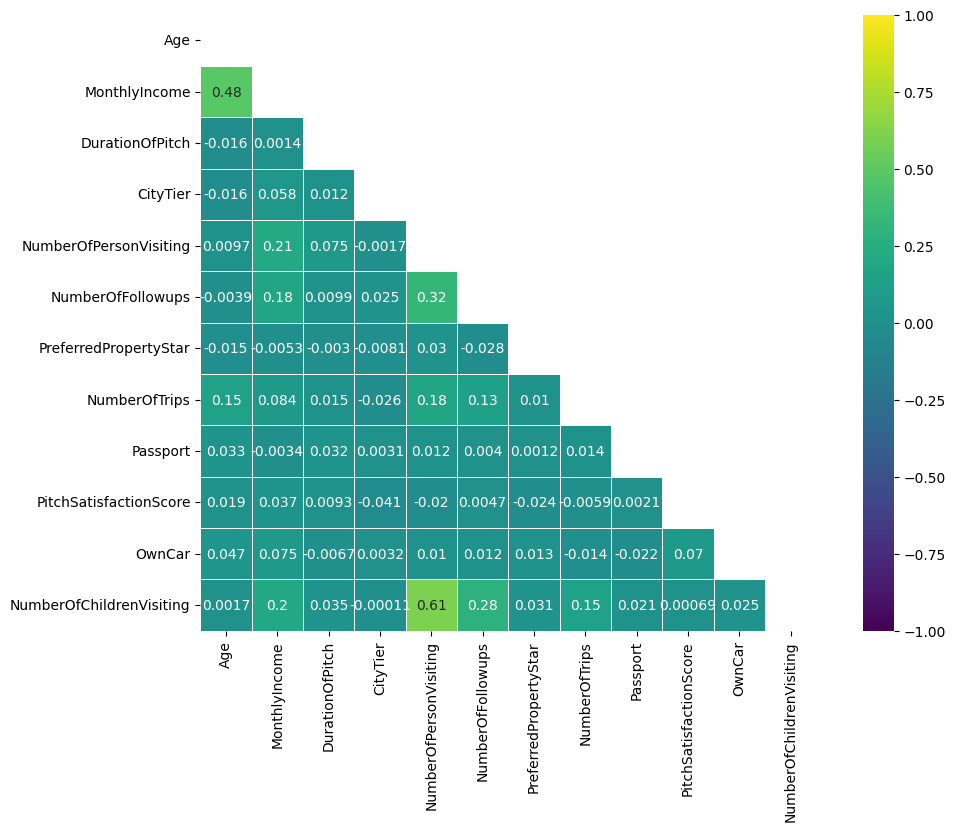

In [45]:
corr(filtered_travel, columns=['Age', 'MonthlyIncome', 'DurationOfPitch', 'CityTier', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting'])

## Modeling - Random Forest

### Putting Feature Variable to X and Target variable to y.

In [46]:
# Putting feature variable to X. 
X = filtered_travel.drop(['CustomerID', 'ProdTaken'], axis=1) 

# Putting target variable to y. 
y = filtered_travel['ProdTaken']

### Split the data

In [47]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Create a Random Forest classifier with class weights
rf = RandomForestClassifier(random_state=42)

# Fit the classifier on the training data
rf.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = rf.score(X_test, y_test)
accuracy

# Predict on the test data
y_pred = rf.predict(X_test)

## Evaluation

In [49]:
start_time = time.time()

classifier_rf = RandomForestClassifier(random_state=42, oob_score=True)

classifier_rf.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds") 

# Checking the oob_score 
print("oob_score:", classifier_rf.oob_score_)

Execution time: 0.28530311584472656 seconds
oob_score: 0.9211267605633803


### Cross Validation

In [50]:
num_folds = 5

# Create a KFold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_results = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')

# Calculate and print the average accuracy
average_accuracy = np.mean(cross_val_results)
print(f"Average Accuracy: {average_accuracy}")

# Calculate and print the standard deviation
std_deviation = np.std(cross_val_results)
print(f"Standard Deviation: {std_deviation}")

Average Accuracy: 0.9055057618437902
Standard Deviation: 0.00917617048254489


### Area Under the ROC Curve

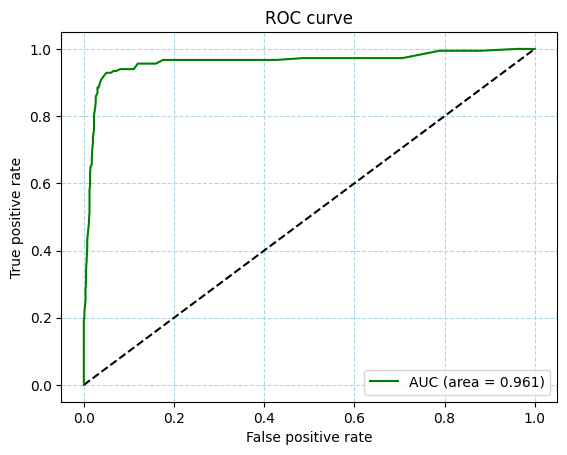

In [51]:
# Predict probabilities on the test data
y_pred_test_proba = rf.predict_proba(X_test)[:, 1]

# Call the auc_plot function
auc_plot(y_test, y_pred_test_proba)

### Classification Report

In [52]:
# Classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       794
           1       0.91      0.63      0.75       183

    accuracy                           0.92       977
   macro avg       0.92      0.81      0.85       977
weighted avg       0.92      0.92      0.91       977



### Confusion Matrix

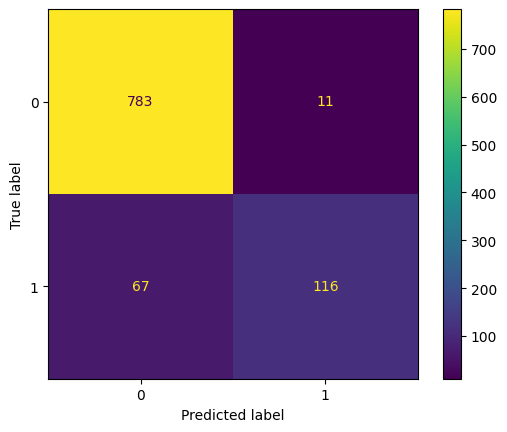

In [53]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### Feature Importances

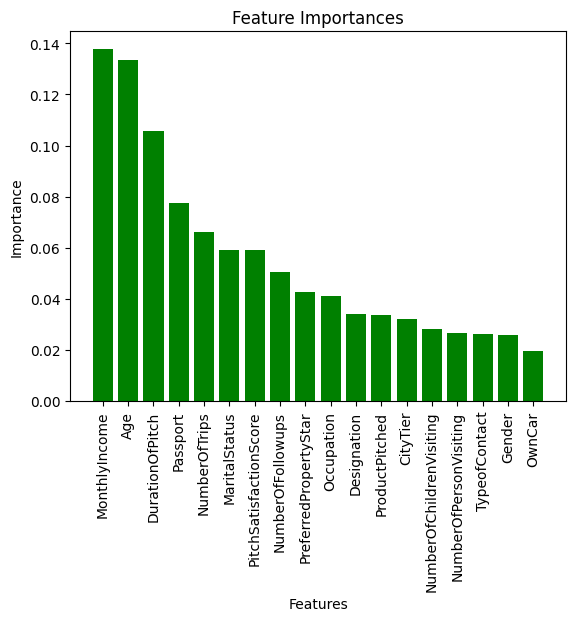

In [54]:
# Call the plot_feature_importances function
plot_feature_importances(rf, X.columns)

In [55]:
# Call the get_feature_importances function
importance_features = get_feature_importances(X_train, rf)
importance_features

,Column,Importance
17,MonthlyIncome,0.137757
0,Age,0.133429
3,DurationOfPitch,0.105848
12,Passport,0.077495
11,NumberOfTrips,0.066254
10,MaritalStatus,0.059258
13,PitchSatisfactionScore,0.058948
7,NumberOfFollowups,0.050449
9,PreferredPropertyStar,0.042846
4,Occupation,0.041034


### Single Tree Visualization

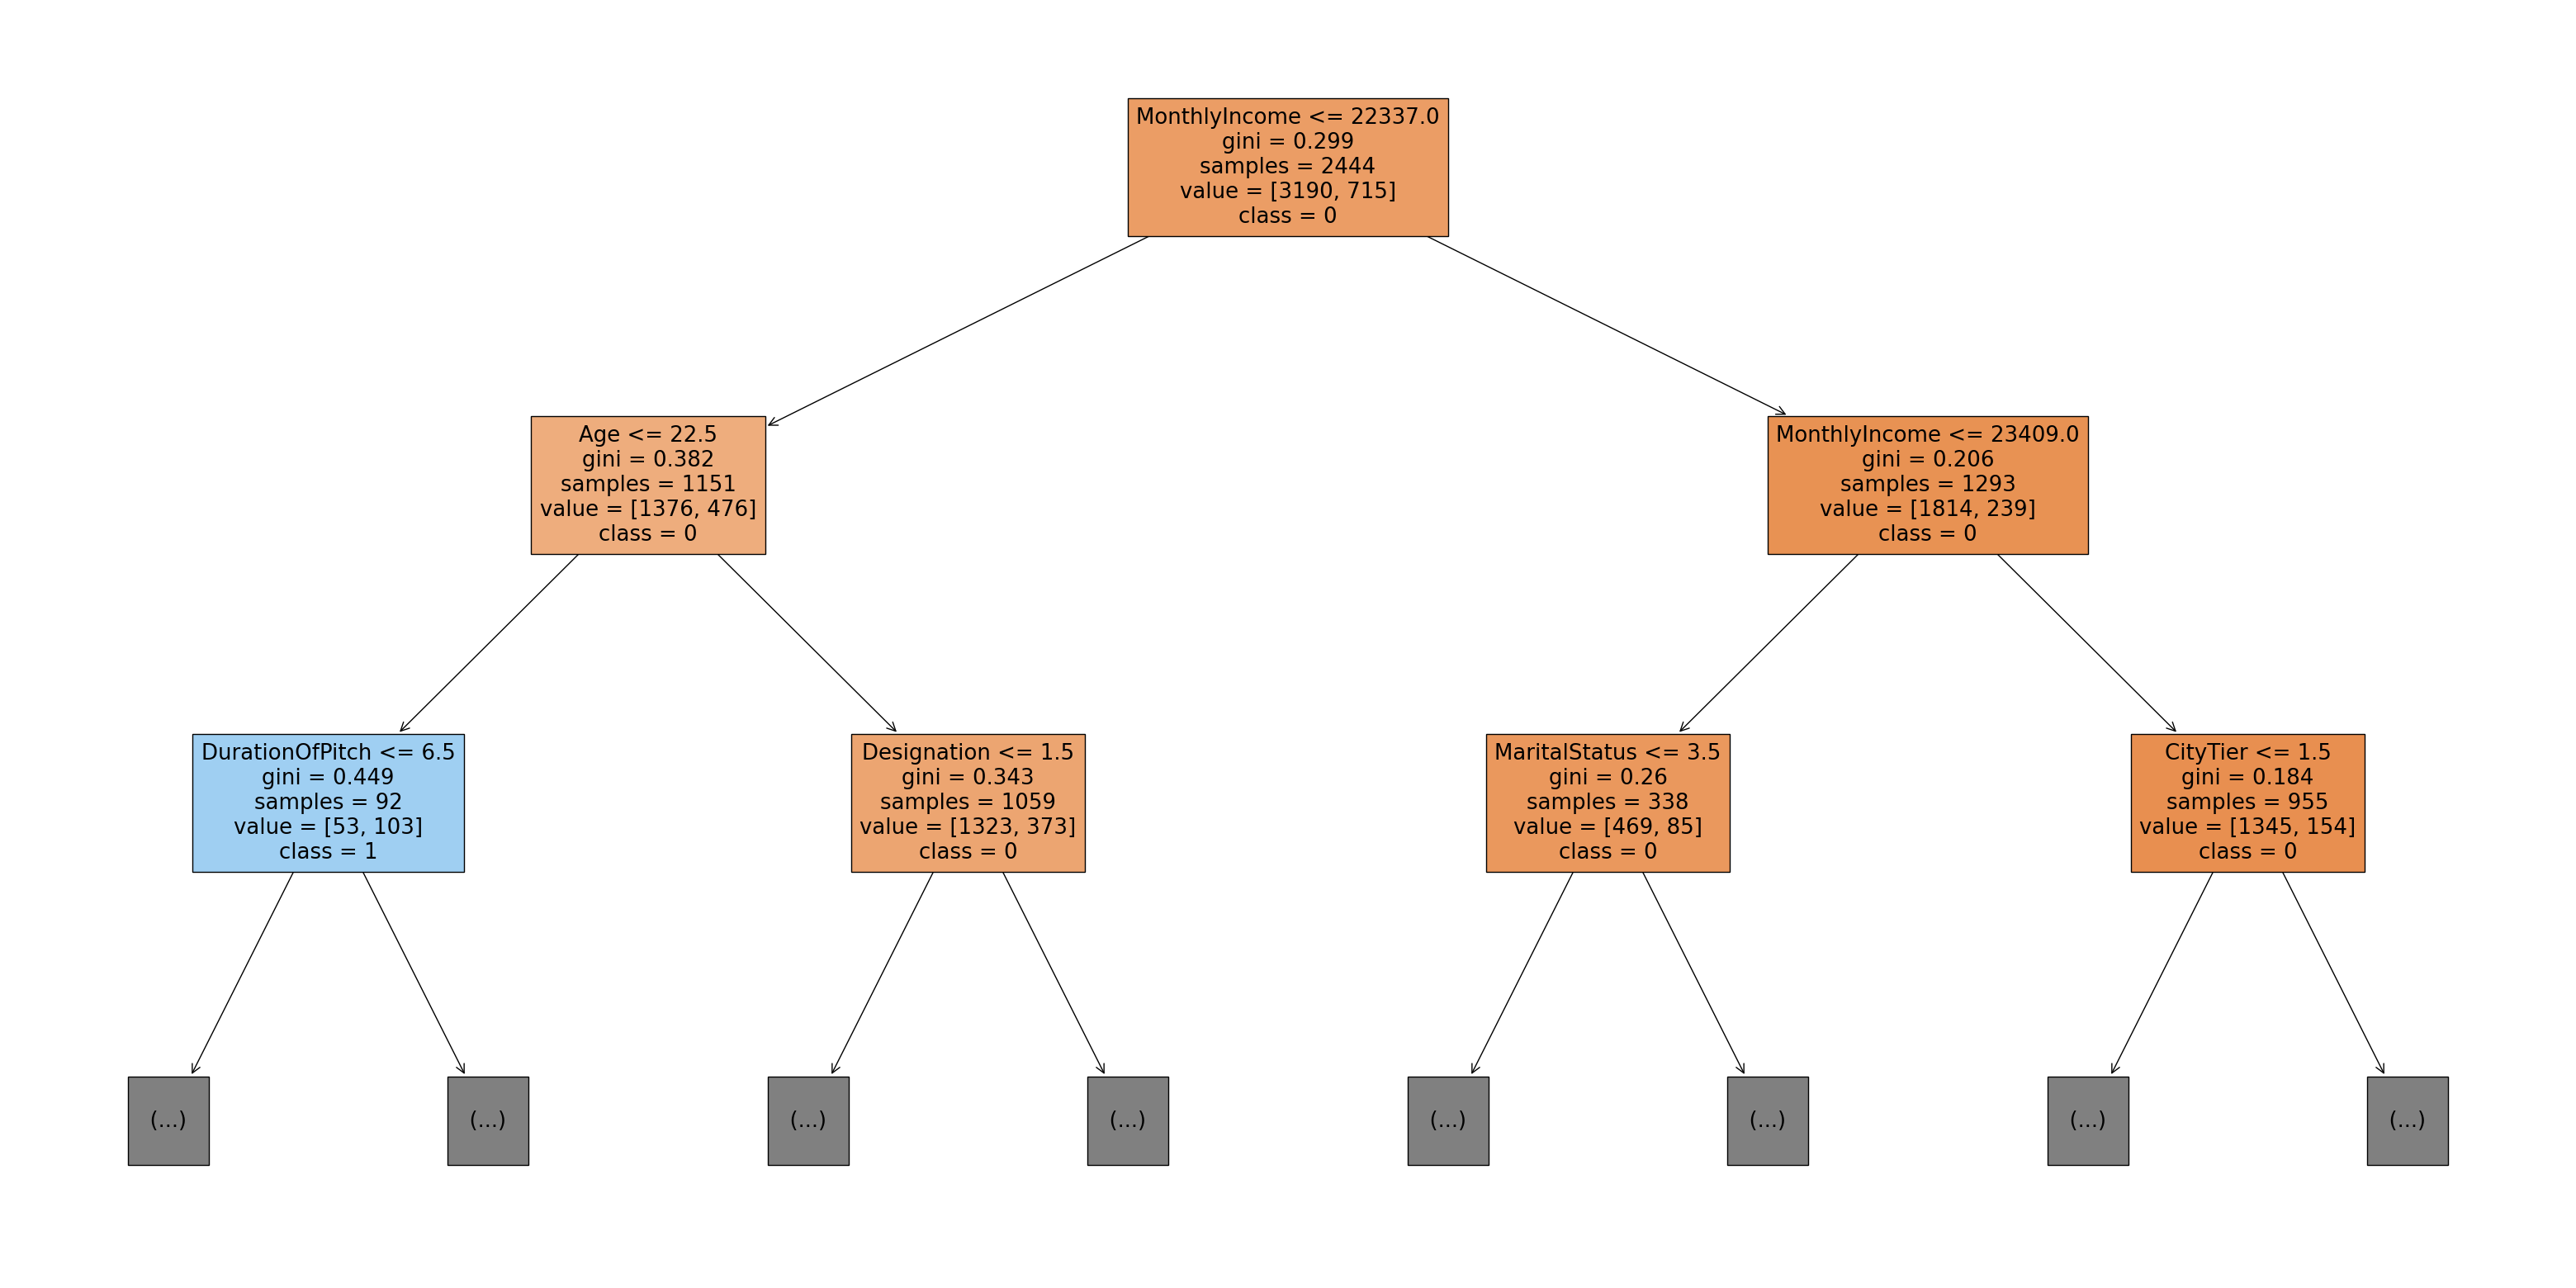

In [56]:
tree_index = 4 
tree_estimator = rf.estimators_[tree_index]

# Plot the decision tree
fig, ax = plt.subplots(figsize=(40, 20))
tree.plot_tree(tree_estimator, feature_names=X_train.columns, class_names=[str(c) for c in rf.classes_], filled=True, ax=ax, max_depth=2)  # Adjust max_depth 

# Set plot title and axis labels
ax.set_xlabel("Features")
ax.set_ylabel("Classes")

# Save the image
desktop_path = os.path.expanduser("~/Desktop")  
image_path = os.path.join(desktop_path, 'tree_visualization.png')
fig.savefig(image_path, bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()

### Hyperparameter Tuning - RandomSearchCV

In [57]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

start_time = time.time()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time 
print("Execution time", execution_time, "seconds")

# Create a variable for the best model
best_rf = rand_search.best_estimator_
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions on the testing data using the best model
y_pred_best = best_rf.predict(X_test)

Execution time 10.907867908477783 seconds
Best hyperparameters: {'max_depth': 18, 'n_estimators': 330}


### Area Under the ROC Curve - best parameters

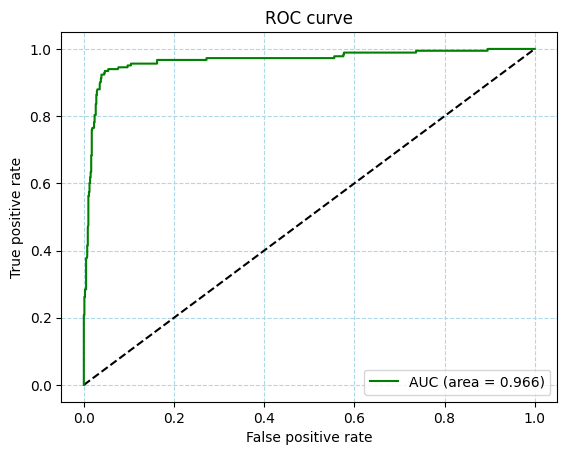

In [58]:
# Call the auc_plot function
y_pred_proba_best = best_rf.predict_proba(X_test)[:, 1]
auc_plot(y_test, y_pred_proba_best)

### Classification Report - best parameters

In [59]:
# Classification report
report = classification_report(y_test, y_pred_best)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       794
           1       0.90      0.64      0.75       183

    accuracy                           0.92       977
   macro avg       0.91      0.81      0.85       977
weighted avg       0.92      0.92      0.91       977



### Confusion Matrix - best parameters

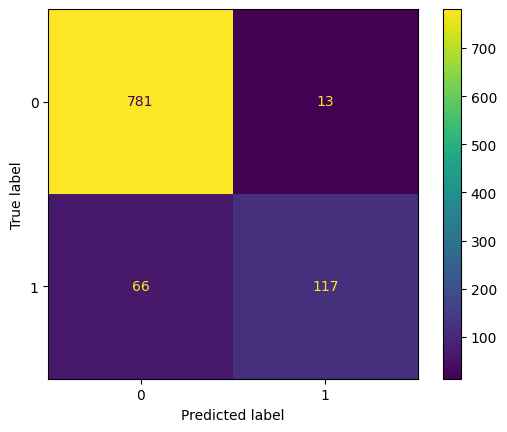

In [60]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### Feature Importances - best parameters

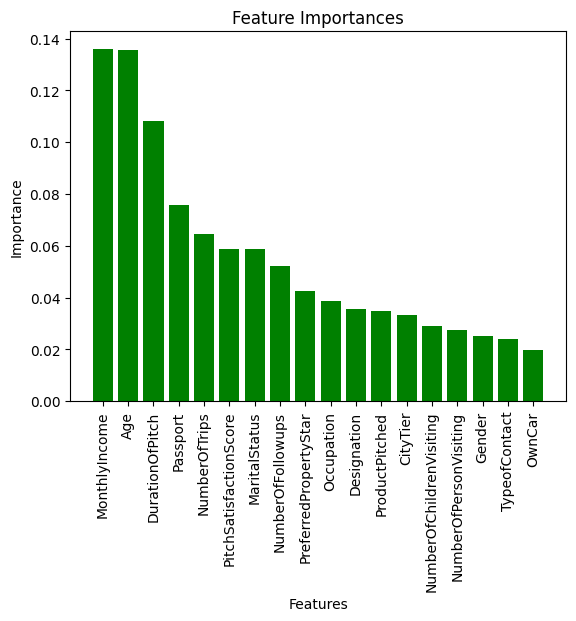

In [61]:
# Call the plot_feature_importances function
plot_feature_importances(best_rf, X.columns)

In [62]:
# Call the get_feature_importances function
importance_features_best = get_feature_importances(X_train, best_rf)
importance_features_best

,Column,Importance
17,MonthlyIncome,0.135935
0,Age,0.135466
3,DurationOfPitch,0.108274
12,Passport,0.075888
11,NumberOfTrips,0.064548
13,PitchSatisfactionScore,0.058915
10,MaritalStatus,0.058826
7,NumberOfFollowups,0.052227
9,PreferredPropertyStar,0.042598
4,Occupation,0.038848


### Single Tree Visualization - best parameters

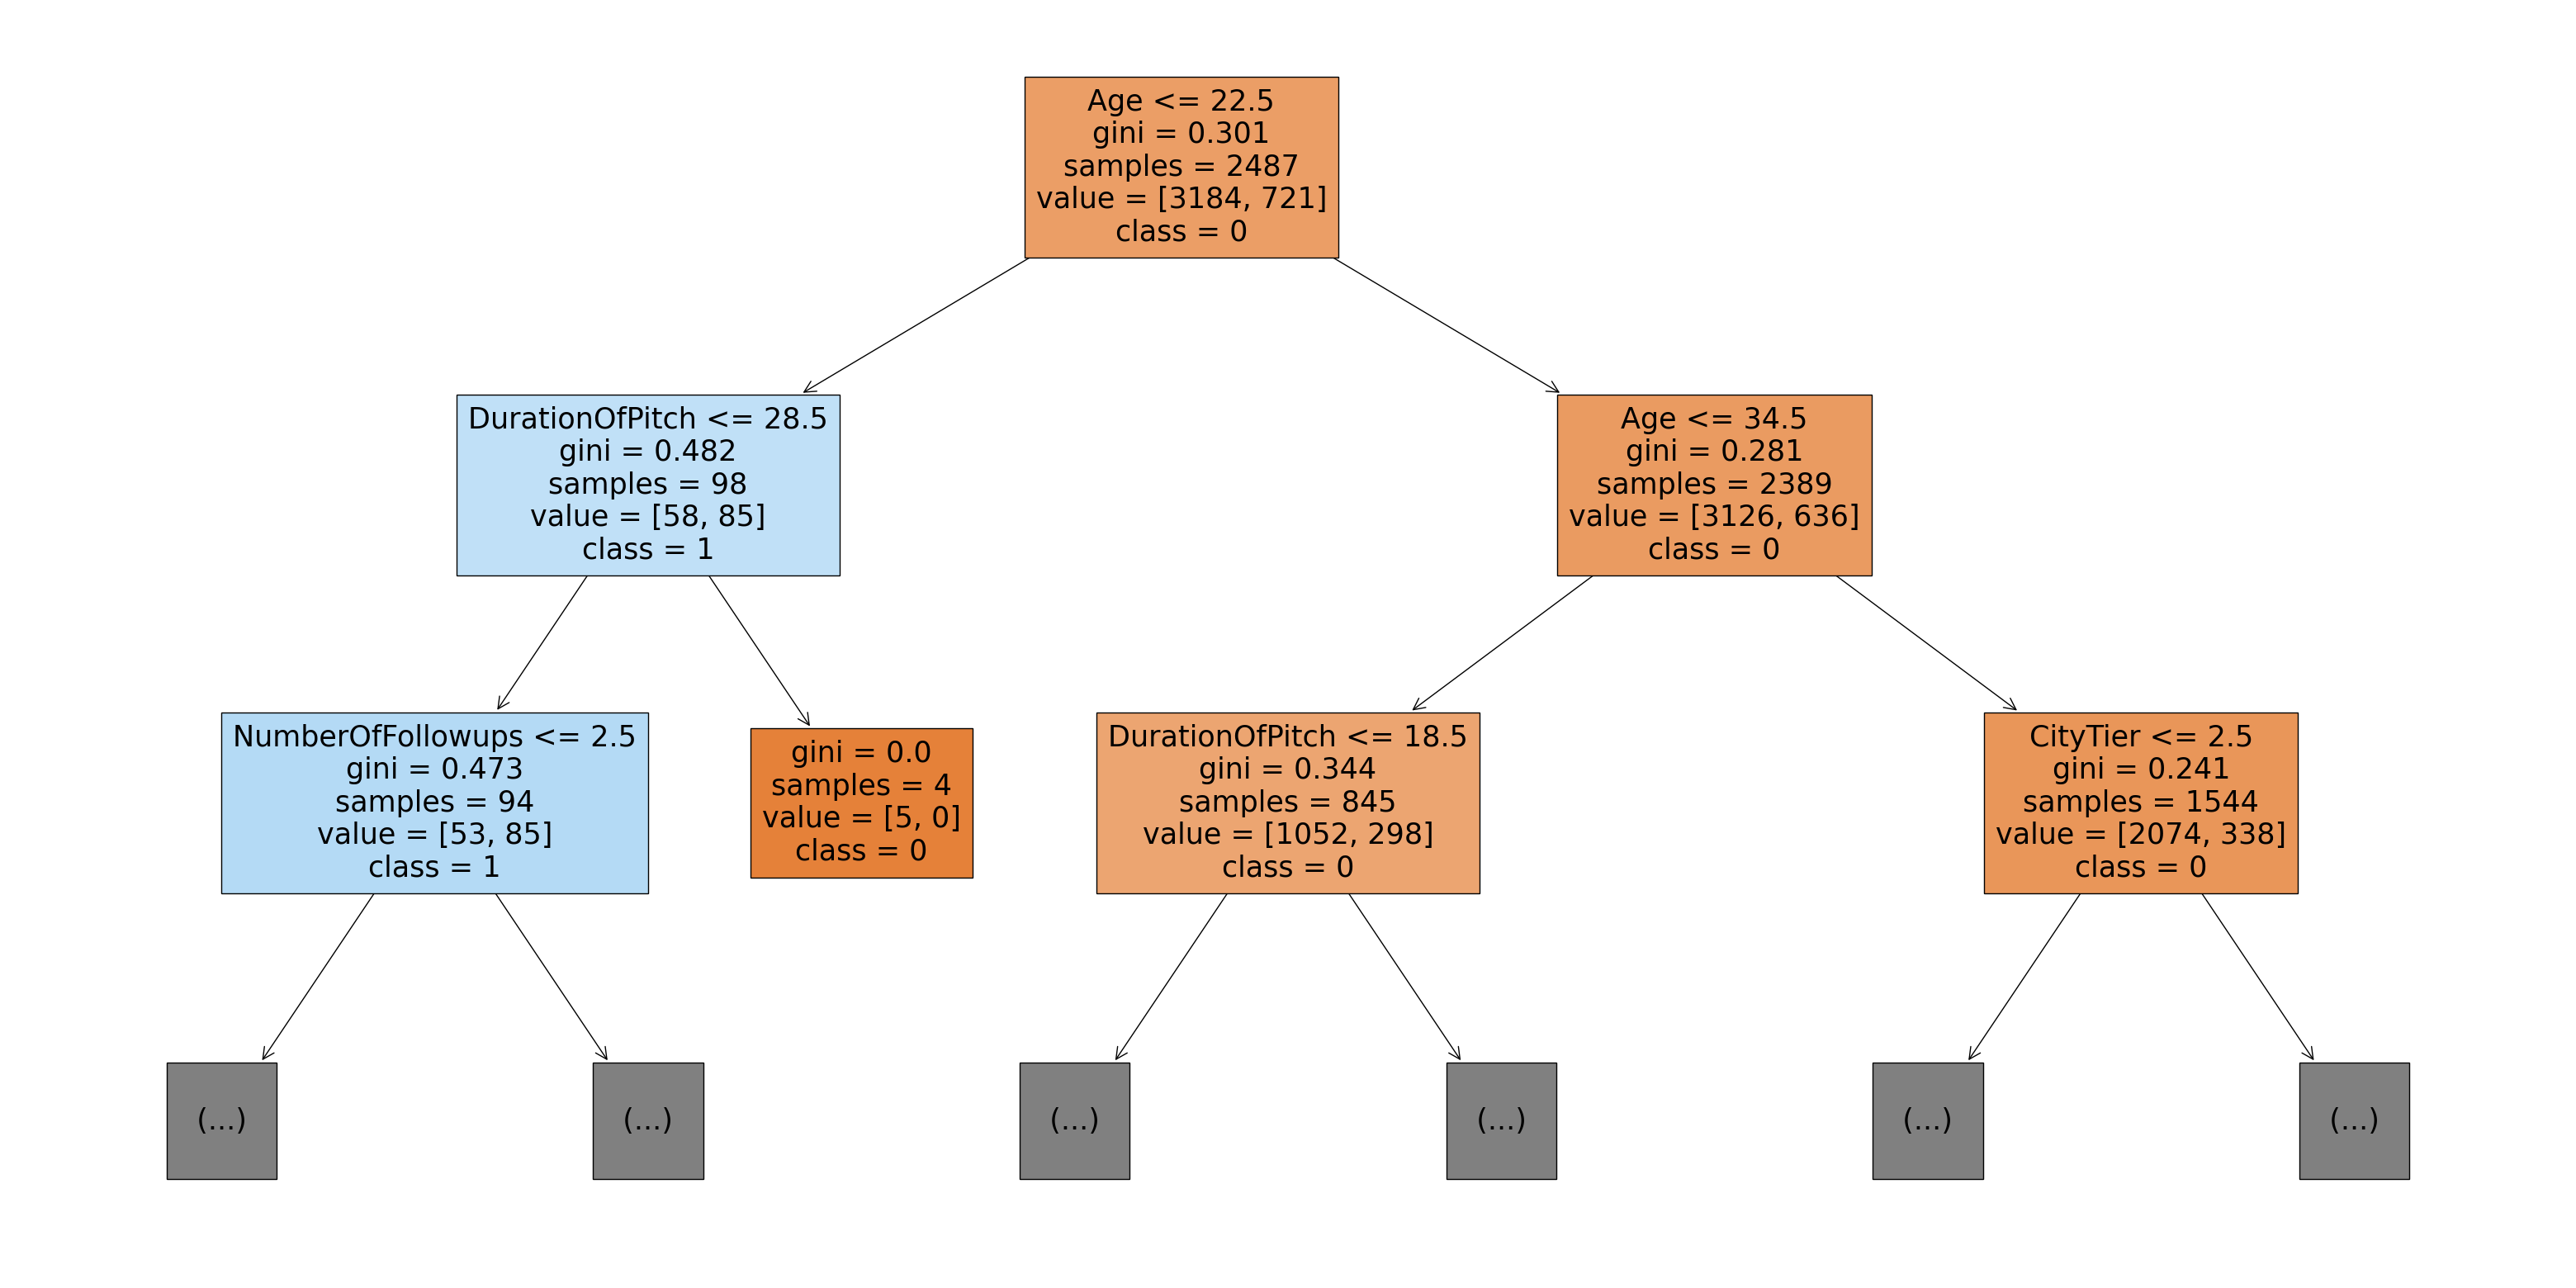

In [63]:
tree_index = 5 
tree_estimator = best_rf.estimators_[tree_index]

# Plot the decision tree
fig, ax = plt.subplots(figsize=(40, 20))
tree.plot_tree(tree_estimator, feature_names=X_train.columns, class_names=[str(c) for c in rf.classes_], filled=True, ax=ax, max_depth=2)  # Adjust max_depth 

# Set plot title and axis labels
ax.set_xlabel("Features")
ax.set_ylabel("Classes")

# Save the image
desktop_path = os.path.expanduser("~/Desktop")  
image_path = os.path.join(desktop_path, 'tree_visualization.png')
fig.savefig(image_path, bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()